In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
%matplotlib inline

In [2]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10), cmap='None'):

    fig = plt.figure(figsize=figsize)
    column = 0shvecova
    for i in range(len(list_of_images)):
        column += 1
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i], cmap)
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

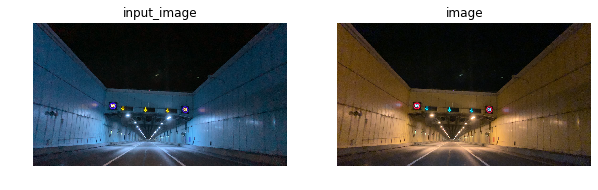

In [69]:
input_image = cv2.imread('img/ROAD_1.PNG') 
image_RGB = input_image.copy()
image_RGB = imutils.resize(image_RGB, height = 700)
image_RGB = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
titles = ["input_image", 
          "image"] 
images = [input_image, 
          image_RGB] 
grid_display(images, titles, 2, (10,10), 'gray')

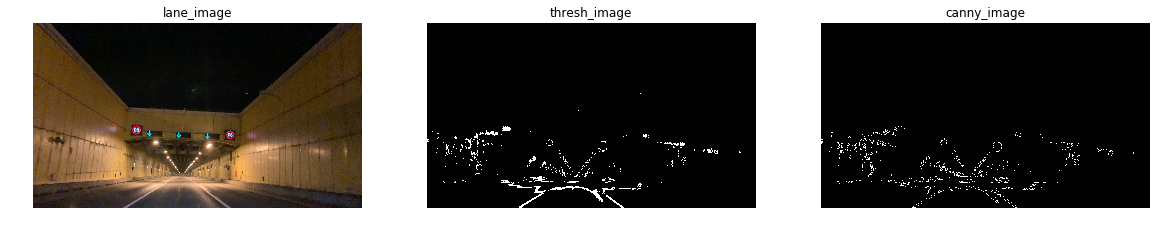

In [70]:
lane_image = image_RGB.copy()
#gray_image = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
hls = cv2.cvtColor(lane_image, cv2.COLOR_RGB2HLS)
h_min = np.array((0, 112, 0))
h_max = np.array((255, 192, 80))
thresh = cv2.inRange(hls, h_min, h_max)
blur_image = cv2.GaussianBlur(thresh, (5, 5), 0)
canny_image = cv2.Canny(blur_image,  50, 150)
titles = ["lane_image", 
          "thresh_image",
          "canny_image"] 
images = [lane_image, 
          thresh,
          canny_image] 
grid_display(images, titles, 3, (20,20), 'gray')

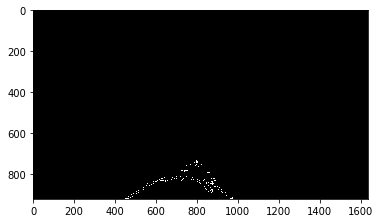

In [71]:
# create func for ROI
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
        [(400, height), (1000, height), (800, 730)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255) 
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# use func
cropped_image = region_of_interest(canny_image)
fig = plt.figure()
plt.imshow(cropped_image, 'gray')

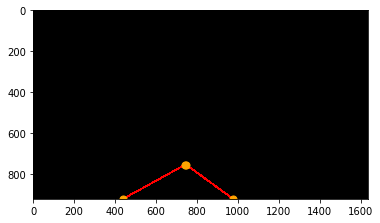

In [72]:
def new_coordinates(image, line_parameters):
    sl, inter = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(9/11))
    x1 = int((y1 - inter)/sl)
    x2 = int((y2 - inter)/sl)
    return np.array([x1, y1, x2, y2])

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength = 30, maxLineGap = 5)
l_fit = []
r_fit = []
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    sl = parameters[0]
    inter = parameters[1]
    if sl < 0:
        l_fit.append((sl, inter))
    else:
        r_fit.append((sl, inter))
# print(l_fit)
# print(r_fit)
l_fit_average = np.average(l_fit, axis=0)
r_fit_average = np.average(r_fit, axis=0)
# print(l_fit_average, 'left')
# print(r_fit_average, 'right')
l_line = new_coordinates(lane_image, l_fit_average)
r_line = new_coordinates(lane_image, r_fit_average)
# print('left', l_line)
# print('right', r_line)
averaged_lines = np.array([l_line, r_line])
# print('averaged_lines', averaged_lines.shape)
# print('----')
# print('CYKA_BLAD', averaged_lines[:])
# print('----')
line_image = np.zeros_like(lane_image)
if averaged_lines is not None:
    for x1, y1, x2, y2 in averaged_lines:
        plt.scatter(x1, y1, s=50, color='orange')
        plt.scatter(x2, y2, s=50, color='orange')
#         print('pizdataya matriza #1' ,averaged_lines[0])
#         print('pizdataya matriza #2' ,averaged_lines[1])
        #x1, y1, x2, y2 = line.reshape(4)
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)

plt.imshow(line_image, 'gray')

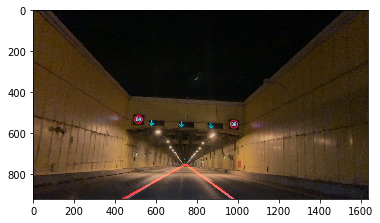

In [73]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.imshow(combo_image)